# GOP Debate Twitter Sentiment Analysis - LSTM

## Author: Ana Lúcia da Cunha Cox (ana.c.cox@gmail.com)

### Goals
Build a machine learning model using long short-term memory(LSTM) and differentiate positive and negative tweets.

### What is sentiment analysis?
Sentiment Analysis is the process of computationally identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral.

### What is LSTM?
Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points (such as images), but also entire sequences of data (such as speech or video). For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition,speech recognition and anomaly detection in network traffic or IDSs (intrusion detection systems).

### What does GOP mean?
The Republican Party picked up the Grand Old Party label in the 1880s, and that’s where the acronym GOP came from. The homespun nickname actually may have been associated with Democrats originally … but that’s another story. However, one thing that is clear is that it was the product of the purple prose style of newspapers in the 19th century.

### Dataset
This data originally came from Crowdflower's Data for Everyone library (https://appen.com/resources/datasets/).

As the original source says: "We looked through tens of thousands of tweets about the early August GOP debate in Ohio and asked contributors to do both sentiment analysis and data categorization. Contributors were asked if the tweet was relevant, which candidate was mentioned, what subject was mentioned, and then what the sentiment was for a given tweet. We've removed the non-relevant messages from the uploaded dataset.".

The data we're providing on Kaggle is a slightly reformatted version of the original source. It includes both a CSV file and SQLite database. The code that does these transformations is available on GitHub (https://github.com/benhamner/crowdflower-first-gop-debate-twitter-sentiment).

### Data Dictionary
    COLUMN      DESCRIPTION
    id                              It is the number of row
    candidate                       Name of candidate mentioned
    candidate_confidence            Number 
    relevant_yn                     Yes or No
    relevant_yn_confidence          Number
    sentiment                       Positive, Negative or Neutral
    sentiment_confidence            Number
    subject_matter                  Tweet subject
    subject_matter_confidence       Number
    candidate_gold                  Name of candidate mentioned
    name                            Name of twitter account
    relevant_yn_gold                Yes or No
    retweet_count                   Retweet amount
    sentiment_gold                  Type of sentiment (Positive 
    subject_matter_gold             Tweet subject
    text                            Tweet text
    tweet_coord                     Tweet coordenation
    tweet_created                   Tweet timestamp 
    tweet_id                        Tweet identification
    tweet_location                  Tweet Location (e.g. Texas)
    user_timezone                   User location (e.g. Arizona, Quito)

                            ------------------------------------------------------

# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
import re

Using TensorFlow backend.


# 2. Import Dataset

In [2]:
sentiment = pd.read_csv("C:/Users/Ana Cox/aceleradev_ds/02. Meu material de aulas/Sentiment.csv")

## 2.1. Understanding the dataset

In [3]:
sentiment

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0000,yes,1.0000,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0000,yes,1.0000,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0000,yes,1.0000,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0000,yes,1.0000,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0000,yes,1.0000,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13866,13867,No candidate mentioned,1.0000,yes,1.0000,Negative,0.7991,Abortion,0.6014,No candidate mentioned,...,yes,7,Negative,Abortion\nWomen's Issues (not abortion though),RT @cappy_yarbrough: Love to see men who will ...,NaN,2015-08-07 09:29:43 -0700,629690895479250944,Como,NaN
13867,13868,Mike Huckabee,0.9611,yes,1.0000,Positive,0.7302,None of the above,0.9229,Mike Huckabee,...,yes,1,NaN,NaN,RT @georgehenryw: Who thought Huckabee exceede...,NaN,2015-08-07 09:25:02 -0700,629689719056568320,USA,NaN
13868,13869,Ted Cruz,1.0000,yes,1.0000,Positive,0.8051,None of the above,0.9647,Ted Cruz,...,yes,67,Positive\nNeutral,NaN,"RT @Lrihendry: #TedCruz As President, I will a...",NaN,2015-08-07 07:19:18 -0700,629658075784282112,NaN,NaN
13869,13870,Donald Trump,1.0000,yes,1.0000,Negative,1.0000,Women's Issues (not abortion though),0.9202,Donald Trump,...,yes,149,NaN,Women's Issues (not abortion though),RT @JRehling: #GOPDebate Donald Trump says tha...,NaN,2015-08-07 09:54:04 -0700,629697023663546368,NaN,NaN


In [4]:
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         13871 non-null  int64  
 1   candidate                  13775 non-null  object 
 2   candidate_confidence       13871 non-null  float64
 3   relevant_yn                13871 non-null  object 
 4   relevant_yn_confidence     13871 non-null  float64
 5   sentiment                  13871 non-null  object 
 6   sentiment_confidence       13871 non-null  float64
 7   subject_matter             13545 non-null  object 
 8   subject_matter_confidence  13871 non-null  float64
 9   candidate_gold             28 non-null     object 
 10  name                       13871 non-null  object 
 11  relevant_yn_gold           32 non-null     object 
 12  retweet_count              13871 non-null  int64  
 13  sentiment_gold             15 non-null     obj

In [5]:
sentiment.isnull().sum()

id                               0
candidate                       96
candidate_confidence             0
relevant_yn                      0
relevant_yn_confidence           0
sentiment                        0
sentiment_confidence             0
subject_matter                 326
subject_matter_confidence        0
candidate_gold               13843
name                             0
relevant_yn_gold             13839
retweet_count                    0
sentiment_gold               13856
subject_matter_gold          13853
text                             0
tweet_coord                  13850
tweet_created                    0
tweet_id                         0
tweet_location                3912
user_timezone                 4403
dtype: int64

This dataset has 13,871 rows and 21 columns, which 4 of them are float64, 3 are int64 and 14 are object type. 

There are entire columns almost null, as "candidate_gold", "relevant_yn_gold", "sentiment_gold", "subject_matter_gold" and "tweet_coord". These variables are qualitative, so let´s drop them from the dataset.

### 2.1.1. Drop select columns

In [6]:
sentiment = sentiment[['id', 'candidate', 'candidate_confidence', 'relevant_yn', 'relevant_yn_confidence', 'sentiment', 'sentiment_confidence', 'subject_matter', 'subject_matter_confidence', 'name', 'retweet_count', 'text', 'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone']]

## 2.2. Basic statistics 

#### Count
It is the total number of rows.

#### Mean
The "average" number; found by adding all data points and dividing by the number of data points.

#### Standard
The standard deviation is a measure of the amount of variation or dispersion of a set of values.

#### Min
It is the lowest value found in the database

#### 25%
The first quartile is essentially the 25th percentile; i.e 25% of the points in the data fall below that value.

#### 50%
The middle number; found by ordering all data points and picking out the one in the middle (or if there are two middle numbers, taking the mean of those two numbers).The line in the middle is the median value of the data. Median is used over the mean since it is more robust to outlier values. 

#### 75%
The third quartile is the 75th percentile; i.e 75% of the points in the data fall below that value.

#### Max
It is the highest value found in the database.

In [7]:
sentiment.describe()

,id,candidate_confidence,relevant_yn_confidence,sentiment_confidence,subject_matter_confidence,retweet_count,tweet_id
count,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,1.387100e+04
mean,6936.000000,0.855689,0.927304,0.756936,0.782801,45.803331,6.296058e+17
std,4004.357127,0.241388,0.141696,0.217682,0.258215,153.981724,9.611863e+13
min,1.000000,0.222200,0.333300,0.186000,0.222200,0.000000,6.294531e+17
25%,3468.500000,0.674200,1.000000,0.651700,0.641300,0.000000,6.294861e+17
50%,6936.000000,1.000000,1.000000,0.681300,1.000000,2.000000,6.296726e+17
75%,10403.500000,1.000000,1.000000,1.000000,1.000000,44.000000,6.296882e+17
max,13871.000000,1.000000,1.000000,1.000000,1.000000,4965.000000,6.297017e+17


# 3. Exploratory Data Analysis

## 3.1. General Analysis

#### Feature candidate

In [8]:
candidate_frequency = pd.concat([pd.DataFrame(sentiment['candidate'].value_counts()),
                pd.DataFrame(sentiment['candidate'].value_counts(normalize=True)*100)], 
                axis=1)

candidate_frequency.columns = ['Quantity candidate', '% candidate']
candidate_frequency

,Quantity candidate,% candidate
No candidate mentioned,7491,54.381125
Donald Trump,2813,20.421053
Jeb Bush,705,5.117967
Ted Cruz,637,4.624319
Ben Carson,404,2.932849
Mike Huckabee,393,2.852995
Chris Christie,293,2.127042
Marco Rubio,275,1.996370
Rand Paul,263,1.909256
Scott Walker,259,1.880218


Viewing in a bar chart

Text(0, 0.5, 'Quantity of mentions')

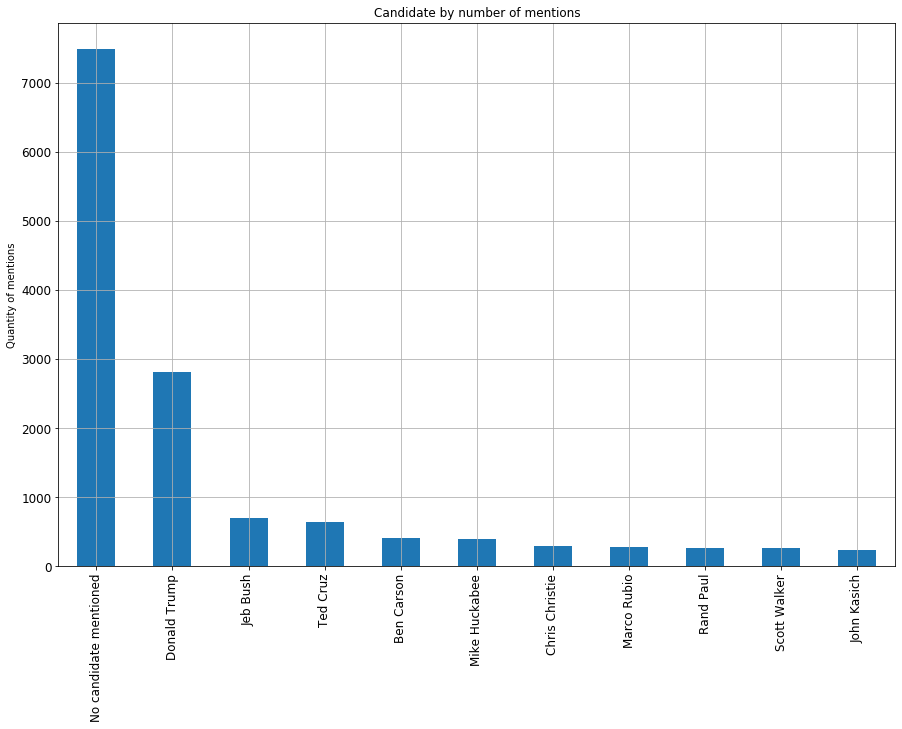

In [9]:
candidate_graphic = sentiment['candidate'].value_counts()

candidate_graphic.plot(kind='bar', 
                          title ="Candidate by number of mentions", 
                          figsize=(15, 10), 
                          legend=False, 
                          fontsize=12).grid()
plt.ylabel('Quantity of mentions')

54.38% of the tweets doesn´t mension any canditate, but Donald Trump is by far the most mentioned politian in relation to the second place Jeb Bush	

#### Feature "candidate_confidence"

It is quantitative variable about canditate confidence.

In [10]:
sentiment['candidate_confidence'].describe()

count    13871.000000
mean         0.855689
std          0.241388
min          0.222200
25%          0.674200
50%          1.000000
75%          1.000000
max          1.000000
Name: candidate_confidence, dtype: float64

It is possible to note that the **mininum confidence is 0.222200**, but the **mean value is 0.855689**. Furthermore, **half percent of the base give the maximum value, that is 1.000000**. 

Viewing in different charts:

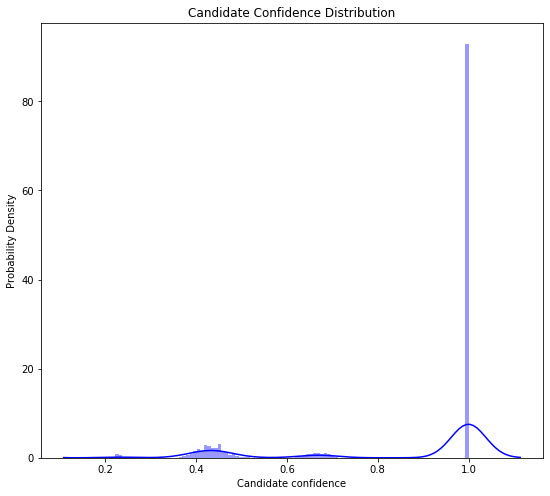

In [11]:
plt.figure(figsize=(9, 8))
sns.distplot(sentiment['candidate_confidence'], 
             color='b',
             bins=100,
             hist_kws={'alpha': 0.4});
plt.xlabel("Candidate confidence")
plt.ylabel("Probability Density")
plt.title("Candidate Confidence Distribution")
plt.show()

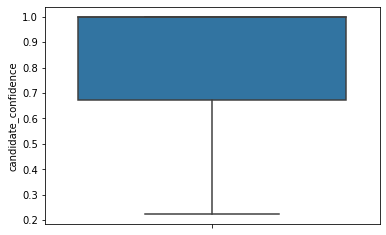

In [12]:
sns.boxplot(y='candidate_confidence', data=sentiment)

#### Feature "relevant_yn"

It is a Yes or No field.  

In [13]:
relevant_yn_frequency = pd.concat([pd.DataFrame(sentiment['relevant_yn'].value_counts()),
                pd.DataFrame(sentiment['relevant_yn'].value_counts(normalize=True)*100)], 
                axis=1)

relevant_yn_frequency.columns = ['Quantity Relevant', '% Relevant']
relevant_yn_frequency

,Quantity Relevant,% Relevant
yes,13871,100.0


A 100% of this variable is relevant. 

#### Feature "relevant_yn_confidence"

It is quantitative variable about relevant confidence.

In [14]:
sentiment['relevant_yn_confidence'].describe()

count    13871.000000
mean         0.927304
std          0.141696
min          0.333300
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: relevant_yn_confidence, dtype: float64

It is possible to note that the **mininum confidence is 0.333300**, but the **mean value is 0.927304**. Furthermore, **half percent of the base give the maximum value, that is 1.000000**. 

#### Feature "sentiment"

It is a qualitative variable which classify if the tweet is:
- Negative
- Neutral
- Positive

In [15]:
sentiment_frequency = pd.concat([pd.DataFrame(sentiment['sentiment'].value_counts()),
                pd.DataFrame(sentiment['sentiment'].value_counts(normalize=True)*100)], 
                axis=1)

sentiment_frequency.columns = ['Quantity Sentiment', '% Sentiment']
sentiment_frequency

,Quantity Sentiment,% Sentiment
Negative,8493,61.228462
Neutral,3142,22.651575
Positive,2236,16.119963


Viewing in a pie chart:

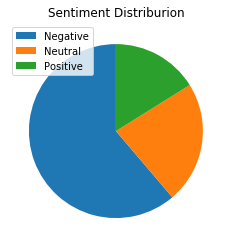

In [16]:
slices, text = plt.pie(sentiment.sentiment.value_counts(), 
                       startangle = 90)
plt.title("Sentiment Distriburion")
plt.legend(['Negative','Neutral','Positive'])
plt.show()

There is more negative or neutral comments than positive.

#### Feature "sentiment_confidence"

It is quantitative variable about sentiment confidence.

In [17]:
sentiment['sentiment_confidence'].describe()

count    13871.000000
mean         0.756936
std          0.217682
min          0.186000
25%          0.651700
50%          0.681300
75%          1.000000
max          1.000000
Name: sentiment_confidence, dtype: float64

It is possible to note that the **mininum confidence is 0.186000**, but the **mean value is 0.756936**. Furthermore, **half percent of the base give 0.681300** and the **maximum value is 1.000000**. 

Viewing in a different charts:

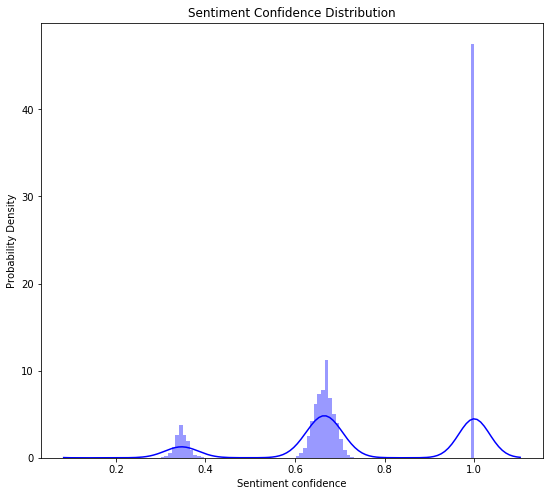

In [18]:
plt.figure(figsize=(9, 8))
sns.distplot(sentiment['sentiment_confidence'], 
             color='b',
             bins=100,
             hist_kws={'alpha': 0.4});
plt.xlabel("Sentiment confidence")
plt.ylabel("Probability Density")
plt.title("Sentiment Confidence Distribution")
plt.show()

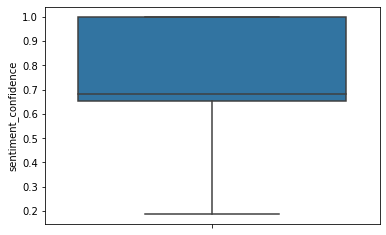

In [19]:
sns.boxplot(y='sentiment_confidence', data=sentiment)

#### Feature "subject_matter"

It is a qualitative variable. 

In [20]:
subject_matter_frequency = pd.concat([pd.DataFrame(sentiment['subject_matter'].value_counts()),
                pd.DataFrame(sentiment['subject_matter'].value_counts(normalize=True)*100)], 
                axis=1)

subject_matter_frequency.columns = ['Quantity Subject Matter', '% Subject Matter']
subject_matter_frequency

,Quantity Subject Matter,% Subject Matter
None of the above,8148,60.155039
FOX News or Moderators,2900,21.410114
Religion,407,3.004799
Foreign Policy,366,2.702104
Women's Issues (not abortion though),362,2.672573
Racial issues,353,2.606128
Abortion,293,2.163160
Jobs and Economy,251,1.853082
Immigration,211,1.557770
LGBT issues,126,0.930233


Viewing the results in a bar chart:

Text(0, 0.5, 'Quantity of tweets')

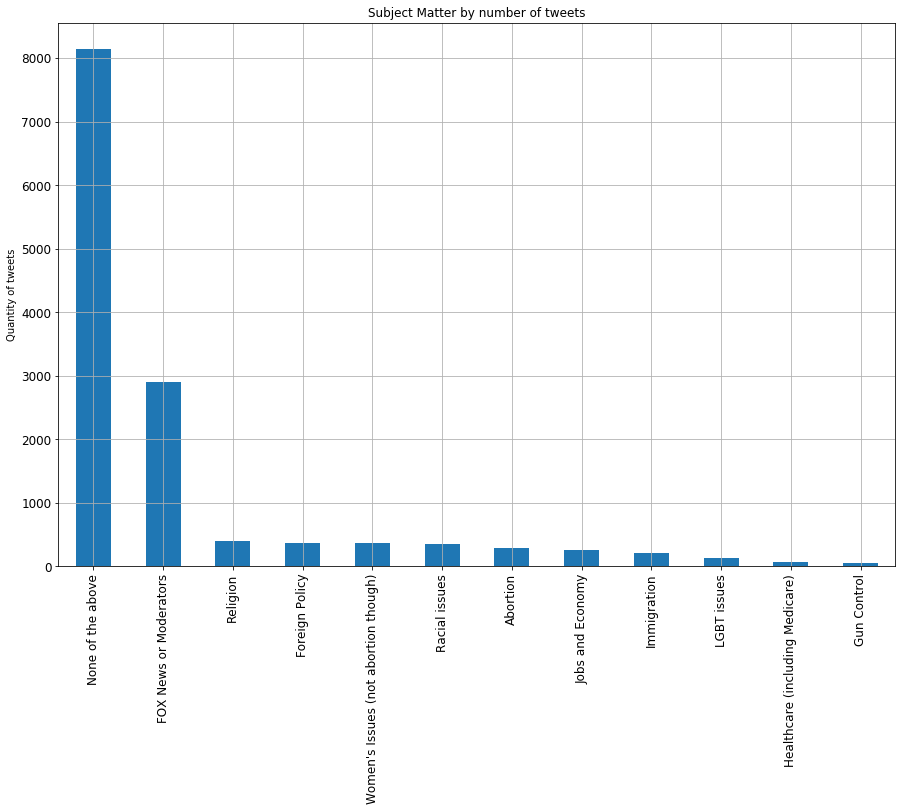

In [21]:
subject_matter_graphic = sentiment['subject_matter'].value_counts()

subject_matter_graphic.plot(kind='bar', 
                          title ="Subject Matter by number of tweets", 
                          figsize=(15, 10), 
                          legend=False, 
                          fontsize=12).grid()
plt.ylabel('Quantity of tweets')

60.16% of the tweet is none of these topics, but by far the FOX News Moderators was comment on Twitter. 

#### Feature "subject_matter_confidence"

It is quantitative variable about subject matter confidence

In [22]:
sentiment['subject_matter_confidence'].describe()

count    13871.000000
mean         0.782801
std          0.258215
min          0.222200
25%          0.641300
50%          1.000000
75%          1.000000
max          1.000000
Name: subject_matter_confidence, dtype: float64

It is possible to note that the **mininum confidence is 0.222200**, but the **mean value is 0.782801**. Furthermore, **half percent of the base give the maximum value, that is 1.000000**. 

Viewing in a different charts:

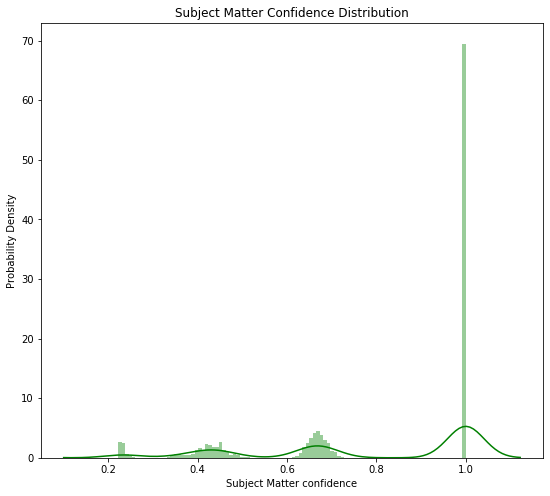

In [23]:
plt.figure(figsize=(9, 8))
sns.distplot(sentiment['subject_matter_confidence'], 
             color='g',
             bins=100,
             hist_kws={'alpha': 0.4});
plt.xlabel("Subject Matter confidence")
plt.ylabel("Probability Density")
plt.title("Subject Matter Confidence Distribution")
plt.show()

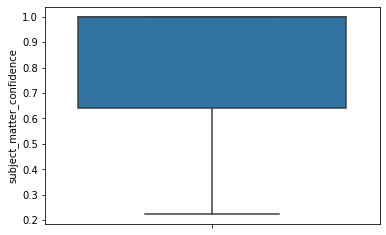

In [24]:
sns.boxplot(y='subject_matter_confidence', data=sentiment)

#### Feature "name"

It is a qualitative variable. It is the name of twitter account.

In [25]:
name_frequency = pd.concat([pd.DataFrame(sentiment['name'].value_counts()),
                pd.DataFrame(sentiment['name'].value_counts(normalize=True)*100)], 
                axis=1)

name_frequency.columns = ['Quantity Name', '% Name']
name_frequency

,Quantity Name,% Name
msgoddessrises,55,0.396511
RT0787,42,0.302790
b140tweet,34,0.245116
jojo21,33,0.237906
SupermanHotMale,32,0.230697
...,...,...
mikafrost,1,0.007209
MotivatedGenY,1,0.007209
thejohnnybshow,1,0.007209
joepilot56,1,0.007209


There is more than 1 tweet per twitter accont. msgoddessrises tweeted 55 times!

#### Feature "retweet_count"

In [26]:
retweet_count_frequency = pd.concat([pd.DataFrame(sentiment['retweet_count'].value_counts()),
                pd.DataFrame(sentiment['retweet_count'].value_counts(normalize=True)*100)], 
                axis=1)

retweet_count_frequency.columns = ['Quantity Retweet', '% Retweet']
retweet_count_frequency

,Quantity Retweet,% Retweet
0,5083,36.644799
1,1465,10.561603
2,694,5.003244
3,402,2.898133
4,240,1.730229
...,...,...
268,1,0.007209
276,1,0.007209
284,1,0.007209
308,1,0.007209


There is a tweet that was retweete 5083 times!

#### Feature "text"

In [27]:
text_frequency = pd.concat([pd.DataFrame(sentiment['text'].value_counts()),
                pd.DataFrame(sentiment['text'].value_counts(normalize=True)*100)], 
                axis=1)

text_frequency.columns = ['Quantity Text', '% Text']
text_frequency

,Quantity Text,% Text
RT @RWSurferGirl: Jeb Bush reminds me of elevator music. You hear it but you don't listen. 🇺🇸 #GOPDebate #GOPDebates,161,1.160695
RT @RWSurferGirl: Fox News is obviously trying to influence the makeup of the Republican field. 🇺🇸 #GOPDebate #GOPDebates,150,1.081393
"RT @RWSurferGirl: It is very disappointing that Fox News is not conducting a ""Fair &amp; Balanced"" Debate. 🇺🇸 #GOPDebate #GOPDebates",142,1.023719
"RT @RWSurferGirl: I think Cruz and Trump need to band together and expose this set up job, and get rid of Bush and Rubio, 🇺🇸 #GOPDebate #G…",140,1.009300
RT @RWSurferGirl: We the American people pick the next President of United States not FOX News 🇺🇸 #GOPDebate #GOPDebates,133,0.958835
...,...,...
RT @TenSecondCynic: Fox News didn't ask one of the #GOPDebates candidates what they planned to do about Mall Walkers.,1,0.007209
"RT @HippieLily: How @_shannonrose17_ and I are dealing with the #GOPDebate 😂 these are the republicans, America http://t.co/tlZ8rK7jr7",1,0.007209
I like @RealBenCarson a lot too but wish he had more air time to express his views. #GOPdebates 🇺🇸,1,0.007209
Keep in mind one thing: politicians are experts at telling voters what they want to hear #GOPDebate,1,0.007209


This table shows the classification of the most repeated texts

#### Feature "tweet_created"

In [28]:
tweet_created_frequency = pd.concat([pd.DataFrame(sentiment['tweet_created'].value_counts()),
                pd.DataFrame(sentiment['tweet_created'].value_counts(normalize=True)*100)], 
                axis=1)

tweet_created_frequency.columns = ['Quantity Tweet Creation', '% Tweet Creation']
tweet_created_frequency

,Quantity Tweet Creation,% Tweet Creation
2015-08-07 08:44:44 -0700,8,0.057674
2015-08-07 09:29:29 -0700,8,0.057674
2015-08-07 09:47:57 -0700,7,0.050465
2015-08-07 09:37:23 -0700,7,0.050465
2015-08-07 08:39:31 -0700,7,0.050465
...,...,...
2015-08-07 08:37:03 -0700,1,0.007209
2015-08-06 19:13:27 -0700,1,0.007209
2015-08-07 03:59:23 -0700,1,0.007209
2015-08-07 08:43:53 -0700,1,0.007209


#### Feature "tweet_id"

In [29]:
tweet_id_frequency = pd.concat([pd.DataFrame(sentiment['tweet_id'].value_counts()),
                pd.DataFrame(sentiment['tweet_id'].value_counts(normalize=True)*100)], 
                axis=1)

tweet_id_frequency.columns = ['Quantity Tweet ID', '% Tweet ID']
tweet_id_frequency

,Quantity Tweet ID,% Tweet ID
629479424153354240,2,0.014419
629678922074992640,2,0.014419
629696650072604672,2,0.014419
629491924915908608,2,0.014419
629671409610944512,2,0.014419
...,...,...
629692290429140992,1,0.007209
629692277745565696,1,0.007209
629692265972154368,1,0.007209
629471869280874497,1,0.007209


#### Feature "tweet_location"

In [30]:
tweet_location_frequency = pd.concat([pd.DataFrame(sentiment['tweet_location'].value_counts()),
                pd.DataFrame(sentiment['tweet_location'].value_counts(normalize=True)*100)], 
                axis=1)

tweet_location_frequency.columns = ['Quantity Tweet Location', '% Tweet Location']
tweet_location_frequency

,Quantity Tweet Location,% Tweet Location
USA,239,2.399839
"Washington, DC",128,1.285270
"New York, NY",120,1.204940
Texas,88,0.883623
United States,75,0.753088
...,...,...
"Florida,Palm Harbor",1,0.010041
Online / Boutiques,1,0.010041
"Lawrence, KS, USA",1,0.010041
ALL Across The Globe,1,0.010041


#### Feature "user_timezone"

In [31]:
user_timezone_frequency = pd.concat([pd.DataFrame(sentiment['user_timezone'].value_counts()),
                pd.DataFrame(sentiment['user_timezone'].value_counts(normalize=True)*100)], 
                axis=1)

user_timezone_frequency.columns = ['Quantity User Timezone', '% User Timezone']
user_timezone_frequency

,Quantity User Timezone,% User Timezone
Eastern Time (US & Canada),3474,36.692015
Central Time (US & Canada),1943,20.521757
Pacific Time (US & Canada),1655,17.479932
Atlantic Time (Canada),461,4.869033
Quito,432,4.562738
...,...,...
Bratislava,1,0.010562
Azores,1,0.010562
Saskatchewan,1,0.010562
PST,1,0.010562


Viewing in a bar chart

## 3.2. Specific Analysis 

#### Candidate *versus* Sentiment

In [32]:
cross_candidate_sentiment = pd.crosstab(sentiment['candidate'],sentiment['sentiment'],margins=True)
cross_candidate_sentiment

sentiment,Negative,Neutral,Positive,All
candidate,,,,
Ben Carson,186,54,164,404
Chris Christie,218,42,33,293
Donald Trump,1758,446,609,2813
Jeb Bush,589,72,44,705
John Kasich,82,47,113,242
Marco Rubio,105,51,119,275
Mike Huckabee,237,83,73,393
No candidate mentioned,4724,2087,680,7491
Rand Paul,148,60,55,263


It´s posible to observe that Donald Trump has more negative comments than positive and neutral. The oposite happens with the candidate Ted Cruz. He has more comments positives than the others.

Text(0, 0.5, 'Quantity of tweets')

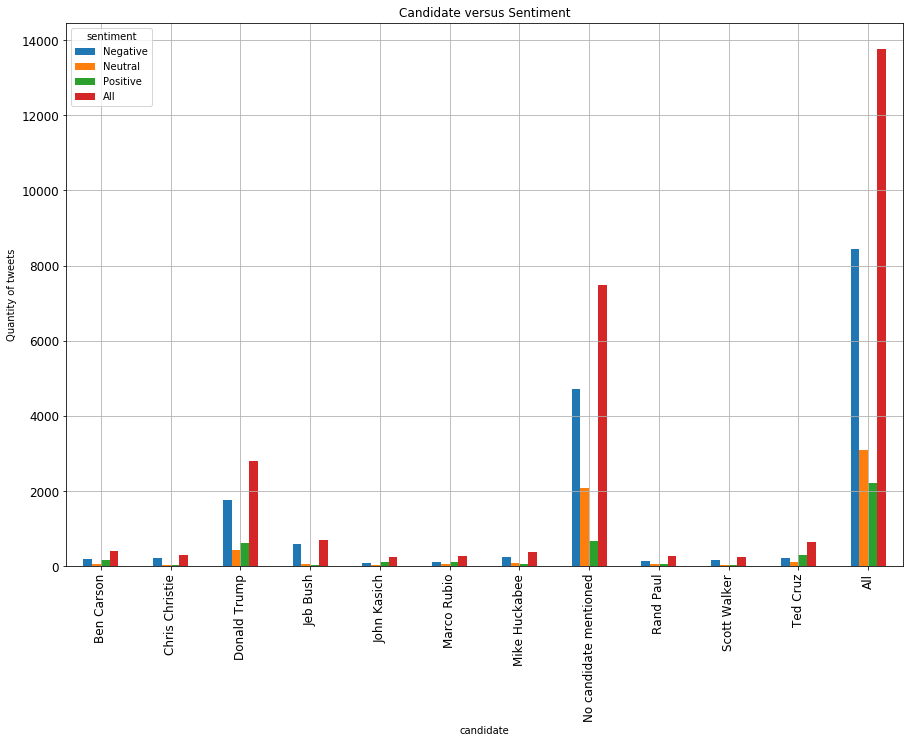

In [33]:
cross_candidate_sentiment.plot(kind='bar', 
                               title ="Candidate versus Sentiment", 
                               figsize=(15, 10), 
                               legend=True, 
                               fontsize=12).grid()
plt.ylabel('Quantity of tweets')

####  Account name *versus* sentiment

In [34]:
cross_name_sentiment = pd.crosstab(sentiment['name'],sentiment['sentiment'],margins=True)
cross_name_sentiment

sentiment,Negative,Neutral,Positive,All
name,,,,
003a04f8c2054b7,1,0,0,1
02C5,1,0,1,2
03forester,1,1,2,4
07Codeman,1,0,0,1
0SweetSolace0,0,1,0,1
...,...,...,...,...
zosoto,1,0,0,1
zumikiss,2,0,0,2
zxnaida,1,0,0,1


#### Sentiment *versus* tweet_location

In [35]:
cross_location_sentiment = pd.crosstab(sentiment['tweet_location'],sentiment['sentiment'],margins=True)
cross_location_sentiment

sentiment,Negative,Neutral,Positive,All
tweet_location,,,,
,4,0,3,7
Southern California,1,0,0,1
"In GOD We Trust, USA",2,2,0,4
Buckeye State,1,0,0,1
#mimimiles ▪ michigan,1,0,0,1
...,...,...,...,...
❤ USA,1,0,0,1
⭕️-H-I-⭕️,0,0,1,1
カリ州ド田舎の秘密基地,2,0,0,2


#### Candidate *versus* tweet_location

In [36]:
cross_location_candidate = pd.crosstab(sentiment['tweet_location'],sentiment['candidate'],margins=True)
cross_location_candidate

candidate,Ben Carson,Chris Christie,Donald Trump,Jeb Bush,John Kasich,Marco Rubio,Mike Huckabee,No candidate mentioned,Rand Paul,Scott Walker,Ted Cruz,All
tweet_location,,,,,,,,,,,,
,0,0,2,0,0,0,0,4,0,0,1,7
Southern California,0,0,1,0,0,0,0,0,0,0,0,1
"In GOD We Trust, USA",0,0,2,0,0,0,0,2,0,0,0,4
Buckeye State,0,0,0,1,0,0,0,0,0,0,0,1
#mimimiles ▪ michigan,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
❤ USA,0,0,1,0,0,0,0,0,0,0,0,1
⭕️-H-I-⭕️,0,0,0,0,1,0,0,0,0,0,0,1
カリ州ド田舎の秘密基地,0,0,0,0,0,0,0,2,0,0,0,2


#### Name *versus* candidate

In [37]:
cross_name_candidate = pd.crosstab(sentiment['name'],sentiment['candidate'],margins=True)
cross_name_candidate

candidate,Ben Carson,Chris Christie,Donald Trump,Jeb Bush,John Kasich,Marco Rubio,Mike Huckabee,No candidate mentioned,Rand Paul,Scott Walker,Ted Cruz,All
name,,,,,,,,,,,,
003a04f8c2054b7,0,1,0,0,0,0,0,0,0,0,0,1
02C5,0,0,1,0,0,0,0,1,0,0,0,2
03forester,0,0,3,0,0,0,0,0,0,0,1,4
07Codeman,0,0,0,0,0,0,0,1,0,0,0,1
0SweetSolace0,0,0,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
zosoto,0,0,0,0,0,0,0,1,0,0,0,1
zumikiss,1,0,0,0,0,0,1,0,0,0,0,2
zxnaida,0,0,0,0,0,0,1,0,0,0,0,1


#### Subject matter *versus* sentiment

In [38]:
cross_subject_matter_sentiment = pd.crosstab(sentiment['subject_matter'],sentiment['sentiment'],margins=True)
cross_subject_matter_sentiment

sentiment,Negative,Neutral,Positive,All
subject_matter,,,,
Abortion,220,45,28,293
FOX News or Moderators,2230,316,354,2900
Foreign Policy,252,75,39,366
Gun Control,50,11,0,61
Healthcare (including Medicare),44,11,12,67
Immigration,118,45,48,211
Jobs and Economy,178,42,31,251
LGBT issues,85,19,22,126
None of the above,4226,2313,1609,8148


#### Subject matter *versus* candidate

In [39]:
cross_subject_matter_candidate = pd.crosstab(sentiment['subject_matter'],sentiment['candidate'],margins=True)
cross_subject_matter_candidate

candidate,Ben Carson,Chris Christie,Donald Trump,Jeb Bush,John Kasich,Marco Rubio,Mike Huckabee,No candidate mentioned,Rand Paul,Scott Walker,Ted Cruz,All
subject_matter,,,,,,,,,,,,
Abortion,1,2,17,12,2,26,18,181,1,29,4,293
FOX News or Moderators,16,11,849,156,4,4,4,1775,5,11,62,2897
Foreign Policy,9,35,26,21,1,3,45,155,13,25,31,364
Gun Control,0,0,2,2,0,0,4,43,9,0,1,61
Healthcare (including Medicare),4,2,6,3,7,1,6,31,1,2,4,67
Immigration,0,6,62,23,0,19,1,87,0,3,6,207
Jobs and Economy,6,7,40,19,10,17,14,120,6,10,2,251
LGBT issues,5,1,1,1,31,2,28,53,2,0,1,125
None of the above,274,221,1604,445,179,181,247,4095,220,145,500,8111


#### Subject matter *versus* tweet location

In [40]:
cross_subject_matter_tweet_location = pd.crosstab(sentiment['subject_matter'],sentiment['tweet_location'],margins=True)
cross_subject_matter_tweet_location

tweet_location,,Southern California,"In GOD We Trust, USA",Buckeye State,#mimimiles ▪ michigan,Ambient,Nashville,فلسطين,"42.73°N, 84.55°W",AMERICA! Angry Yet? NY'er,...,♫ Nashville ♫,♰ #WeAreN ♰,✈️ Birmingham ✈️ Brooklyn ✈️,✡ Pittsburgh / NYC ✡,✨ the grumpiest dragon ✨,❤ USA,⭕️-H-I-⭕️,カリ州ド田舎の秘密基地,哈尔滨—青岛(✓)—魔都—帝都,All
subject_matter,,,,,,,,,,,,,,,,,,,,,
Abortion,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,201
FOX News or Moderators,2,1,3,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,2,0,1965
Foreign Policy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,248
Gun Control,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,47
Healthcare (including Medicare),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,52
Immigration,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,147
Jobs and Economy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,183
LGBT issues,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,94
None of the above,5,0,1,1,0,1,1,1,0,0,...,1,1,1,0,0,0,1,0,1,5968


#### Subject matter versus candidate and sentiment

In [41]:
cross_subject_matter_candidate_sentiment = pd.crosstab([sentiment.subject_matter,sentiment.candidate],sentiment.sentiment)
cross_subject_matter_candidate_sentiment

sentiment                                                    Negative  \
subject_matter                       candidate                          
Abortion                             Ben Carson                     1   
                                     Chris Christie                 1   
                                     Donald Trump                  10   
                                     Jeb Bush                       7   
                                     John Kasich                    2   
...                                                               ...   
Women's Issues (not abortion though) Marco Rubio                    1   
                                     Mike Huckabee                  9   
                                     No candidate mentioned       196   
                                     Rand Paul                      0   
                                     Scott Walker                   4   

sentiment                                                    Neutral  Positive  
subject_matter                       candidate                                  
Abortion                             Ben Carson                    0         0  
                                     Chris Christie                1         0  
                                     Donald Trump                  3         4  
                                     Jeb Bush                      4         1  
                                     John Kasich                   0         0  
...                                                              ...       ...  
Women's Issues (not abortion though) Marco Rubio                   1         1  
                                     Mike Huckabee                 1         0  
                                     No candidate mentioned       23         1  
                                     Rand Paul                     0         1  
                                     Scott Walker                  0         0  

[120 rows x 3 columns]

# 4. Data Modeling

## 4.1. Clean database

Drop Neutral words

In [42]:
sentiment = sentiment[sentiment.sentiment != "Neutral"]

Now, let´s filter the tweets so only valid texts and words remain.

In [43]:
sentiment['text'] = sentiment['text'].apply(lambda x: x.lower())
sentiment['text'] = sentiment['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print('Words on "text" column:\n')
print('Total of Words: ',sentiment.size)
print('Positive Words: ',sentiment[sentiment['sentiment'] == 'Positive'].size)
print('Negative Words: ',sentiment[sentiment['sentiment'] == 'Negative'].size)

Words on "text" column:

Total of Words:  171664
Positive Words:  35776
Negative Words:  135888


Defining the number of max features as 2000 and use Tokenizer to vectorize and convert text into Sequences so the Network can deal with it as input.

In [44]:
max_fatures = 2000
tokenizer = Tokenizer(nb_words=max_fatures, split=' ')
tokenizer.fit_on_texts(sentiment['text'].values)
X = tokenizer.texts_to_sequences(sentiment['text'].values)
X = pad_sequences(X)

C:\Users\Ana Cox\anaconda3\lib\site-packages\keras_preprocessing\text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


## 4.2. LSTM Network

Next, I compose the LSTM Network. Note that embed_dim, lstm_out, batch_size, droupout_x variables are hyperparameters, their values are somehow intuitive, can be and must be played with in order to achieve good results. Please also note that I am using softmax as activation function. The reason is that our Network is using categorical crossentropy, and softmax is just the right activation method for that.

In [45]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1], dropout=0.2))
model.add(LSTM(lstm_out, dropout_U=0.2, dropout_W=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

C:\Users\Ana Cox\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  """
C:\Users\Ana Cox\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(196, dropout=0.2, recurrent_dropout=0.2)`
  


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 28, 128)           256000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


## 4.3. Split the dataset into train and test 

In [46]:
Y = pd.get_dummies(sentiment['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)

print('Dimensions of train and test datasets:\n')
print('X_train: ',X_train.shape)
print('Y_train: ',Y_train.shape)
print('X_test: ',X_test.shape)
print('Y_test: ',Y_test.shape)

Dimensions of train and test datasets:

X_train:  (7188, 28)
Y_train:  (7188, 2)
X_test:  (3541, 28)
Y_test:  (3541, 2)


## 4.4. Train the Network

We should run much more than 7 epoch, but I would have to wait forever for kaggle, so it is 7 for now.

In [47]:
batch_size = 32
model.fit(X_train, Y_train, nb_epoch = 7, batch_size=batch_size, verbose = 2)

C:\Users\Ana Cox\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
C:\Users\Ana Cox\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/7
 - 32s - loss: 0.4269 - accuracy: 0.8179
Epoch 2/7
 - 28s - loss: 0.3038 - accuracy: 0.8696
Epoch 3/7
 - 30s - loss: 0.2654 - accuracy: 0.8879
Epoch 4/7
 - 29s - loss: 0.2236 - accuracy: 0.9087
Epoch 5/7
 - 29s - loss: 0.1985 - accuracy: 0.9211
Epoch 6/7
 - 32s - loss: 0.1723 - accuracy: 0.9317
Epoch 7/7
 - 28s - loss: 0.1552 - accuracy: 0.9386


## 4.5. Extract validation set

In [48]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]

#### Measure score and Accuracy

In [49]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("Score: %.2f" % (score))
print("Accuracy: %.2f" % (acc))

Score: 0.52
Accuracy: 0.83


## 4.6. Algorithm score

Now, let´s measure the number of correct guesses. It is clear that finding negative tweets goes very well for the Network but deciding whether is positive is not really.

The method to quantify the assertiveness of the classifier model was count the test rows divided by the number of words categorized by the algorithm.

In [50]:
pos_cnt = 0
neg_cnt = 0
pos_correct = 0
neg_correct = 0


for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("Accuracy Positive Words: ", pos_correct/pos_cnt*100, "%")
print("Accuracy Negative Words:", neg_correct/neg_cnt*100, "%")

Accuracy Positive Words:  57.28155339805825 %
Accuracy Negative Words: 90.09235936188077 %
